# Preprocesamiento de Datos

El preprocesamiento de datos - a veces también conocido como transformación de datos o, incluso, ingeniería de atributos - es probablemente una de las parte más importante del trabajo del Data Scientist, tal vez la más importante. Como habrás visto en la bitácora, son muchos los pasos involucrados en este proceso, y eso que no los hemos mencionados a todos, pero sí los más importantes. En este notebook, trabajaremos sobre cuatro grandes áreas:

1. Valores Faltantes
2. Valores Atípicos
3. Escalado de Datos
4. Encoders

Como este notebook corresponde a dos bitácoras y encuentros (19 y 20), no te preocupes si todavía no sabes de qué se tratan los puntos 3 y 4.

Antes de arrancar, una pregunta usual que suele surgir es si usar Pandas o Scikit-Learn, ya que algunos de estos pasos pueden hacerse indistintamente con cualquiera de las dos librerías. Como siempre, la respuesta depende de lo que quieras hacer - y también con cuál herramienta te sientas más cómodo/a. Pero una respuesta rápida es que si estas explorando datos, mejor usar Pandas. Si estás en un flujo de Machine Learning, Scikit-Learn. Probablemente, termines usando las dos en un mismo notebook.

#### Algunas referencias

**Muy útil:** [documentación de Scikit-Learn sobre preprocesamiento de datos](https://scikit-learn.org/stable/modules/preprocessing.html)

**Valores Faltantes**

* En Pandas, explora las funcionalidades `isna()`, `dropna()` y `fillna()`.
* En Scikit-Learn, explora la clase `SimpleImputer`.

**Valores Atípicos**

* Para aplicar los criterios que mencionamos, bastará usar las técnicas de visualización que ya conoces, calcular percentiles, promedios y desviaciones estándar con NumPy o Pandas, y usar máscaras.
* En Scikit-Learn existen métodos para trabajar con valores atípicos. Si bien no los utilizaremos, no está demás si quieres mirarlos [aquí](https://scikit-learn.org/stable/modules/outlier_detection.html).

**Escalado de Datos**
* Se puede hacer a mano con las herramientas de NumPy o Pandas
* En Scikit-Learn existe una variedad de clases que pueden ayudarte en este proceso. Puedes mirar en el enlace a la documentación de Scikit-Learn que dejamos más arriba.

**Encoders**
* En Pandas, explora las funcionalidades `get_dummies()` y `map()`
* En Scikit-Learn, explora la clase `LabelEncoder` y `OneHotEncoder`.


## 1. Valores Faltantes

En este ejercicio te proveemos de un dataset de seis columnas y 1500 instancias. Salvo una columna, `V1`, todas tienen valores faltantes. De las columnas con valores faltantes:
* Dos tienen valores faltantes MCAR (el valor faltante es completamente al azar y no depende de otras variables)
* Una tiene valores faltantes MAR (la probabilidad de valor faltante depende de otra variable).
* Una tiene valores faltantes MNAR (la probabilidad de valor faltante depende de esa misma variable).

### 1.1 MCAR, MAR o MNAR

El objetivo de esta sección es que analisis el origen de estos valores faltantes. Para ello:

1. Abre los datos y explóralos. Con ese fin, te recomendamos hacer un `pairplot` (con y sin `hue`) de Seaborn y contar los valores faltantes por columna. ¿Qué tipo de datos son?¿Cuáles son sus distribuciones?¿Te parece que hay alguna columna correlacionada con otra?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('DS_Bitácora_19_Data_con_VF.csv')
data.shape

(1500, 5)

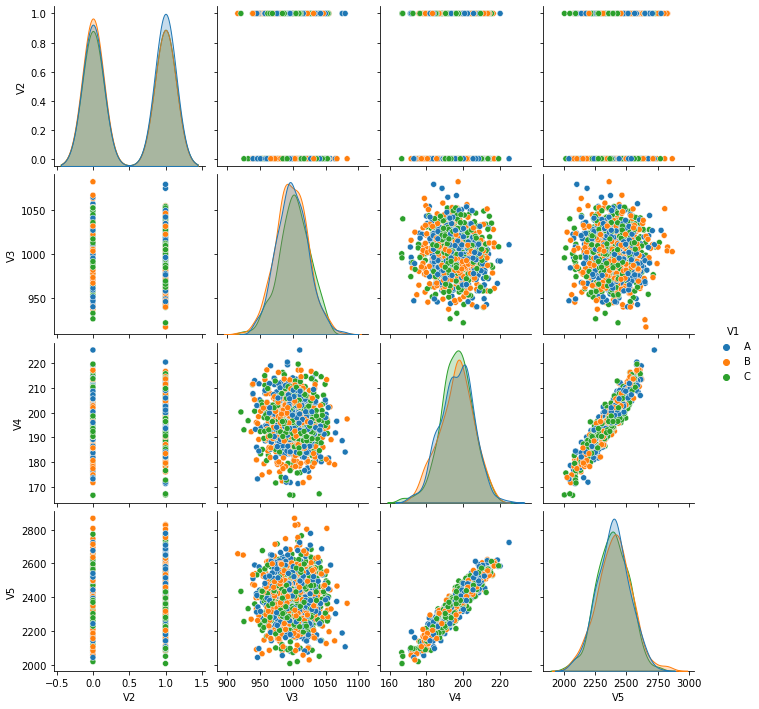

In [3]:
sns.pairplot(data, hue = 'V1', hue_order=['A', 'B', 'C'])
plt.show()

In [4]:
data.isna().sum()

V1      0
V2    159
V3    104
V4    413
V5    118
dtype: int64

2. Buscaremos decidir el mecanismo que dio origen a los valores faltante de cada columna. Para ello, ten en cuenta que:
* Para simplificar el análisis, si hay valores MAR, la dependencia sólo puede ser con la columna categórica sin valores faltantes, `V1`. Entonces, basta que solamente pruebes dependencia con esa variable. Te puede ser **muy útil** [esta pregunta de Stack Overflow](https://stackoverflow.com/questions/43321455/pandas-count-null-values-in-a-groupby-function/43322220).
* MNAR puede es difícil de estudiar si no tenemos conocimiento del tema o si no hay una variable que correlacione con la variable que queremos estudiar para usar de *proxy*. ¿Qué queremos decir con esto? Imaginate que tienes una planilla con sueldos mensuales de personas y vas a borrar valores con mayor probabilidad si son más altos. Pero no te diste cuenta que en otra planilla figuran el estimativo del sueldo anual, lo cual correlaciona fuertemente con el sueldo mensual. Entonces, si quieres ver si la probabilidad de borrar un valor estaba relacionada con ese valor, lo que puedes hacer es crear intervalos para la variables sin valores faltantes - es decir, crear rangos de sueldos anuales - y contar cuántas instancias que caen dentro de ese intervalo tienen valores faltantes en la variable borrada (sueldo mensual). Al principio es muy confuso, pero piénsalo un rato y vas a ver que tiene sentido.
* MCAR es un mecanismo que puede ser difícil de estudiar. Tal vez es más probable que llegues a él *por descarte* de los otros dos mecanismos.

**MAR con respecto a `V1`**

In [5]:
data.V2.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

V1  count
0  A     39
1  B     52
2  C     68

In [6]:
data.V3.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

V1  count
0  A     30
1  B      0
2  C     74

In [7]:
data.V4.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

V1  count
0  A    139
1  B    147
2  C    127

In [8]:
data.V5.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

V1  count
0  A     34
1  B     44
2  C     40

Notar que la única variable que parece tener una dependencia fuerte en sus valores faltantes con `V1` es `V3`.

**MNAR**

Las únicas variables correlacionadas son `V4` y `V5`, ambas con valores faltantes. Entonces, podemos usar una para ver si los valores faltantes de la otra son **MNAR**.

Arranquemos estudiando los valores faltante en `V5`. Para ello, debemos binear `V4` y contar cuántos valores faltantes de `V5` caen en cada intervalo. Entonces, creamos los intervalos para `V4`

In [9]:
data['V4-intervalos'] = pd.cut(data.V4, bins  = 15)
data

V1   V2           V3          V4           V5       V4-intervalos
0     C  1.0   986.175237  184.258917  2224.638050  (182.265, 186.168]
1     C  1.0   994.130276         NaN  2570.213101                 NaN
2     A  1.0   985.782622  196.893581  2309.238832  (193.974, 197.876]
3     A  1.0  1029.464887  192.063247  2349.259233  (190.071, 193.974]
4     A  1.0  1004.357092         NaN  2474.036357                 NaN
...  ..  ...          ...         ...          ...                 ...
1495  C  0.0   985.188653  190.366109  2302.000694  (190.071, 193.974]
1496  C  0.0   991.730134  193.553401  2277.045998  (190.071, 193.974]
1497  B  0.0  1032.150519         NaN  2347.760632                 NaN
1498  C  1.0   984.522924  196.373516  2393.847484  (193.974, 197.876]
1499  C  0.0  1017.399835  192.406202  2368.906782  (190.071, 193.974]

[1500 rows x 6 columns]

y contamos cuántas instancias por intervalo tienen valores faltantes en `V5`.

In [10]:
vf_V4V5 = data.V5.isnull().groupby([data['V4-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V4V5

V4-intervalos  count
0   (166.596, 170.557]      0
1    (170.557, 174.46]      0
2    (174.46, 178.363]      1
3   (178.363, 182.265]      2
4   (182.265, 186.168]      5
5   (186.168, 190.071]      6
6   (190.071, 193.974]     17
7   (193.974, 197.876]     12
8   (197.876, 201.779]     20
9   (201.779, 205.682]     13
10  (205.682, 209.585]      5
11  (209.585, 213.487]      6
12   (213.487, 217.39]      2
13   (217.39, 221.293]      0
14  (221.293, 225.196]      0

Pero en realidad lo que nos interesa es la frecuencia de estos valores faltantes, porque no todos los intervalos tienen la misma cantidad de instancias.

In [11]:
vf_V4V5['freq'] = vf_V4V5['count']/data.groupby([data['V4-intervalos']]).count()['V4'].values
vf_V4V5

V4-intervalos  count      freq
0   (166.596, 170.557]      0  0.000000
1    (170.557, 174.46]      0  0.000000
2    (174.46, 178.363]      1  0.062500
3   (178.363, 182.265]      2  0.051282
4   (182.265, 186.168]      5  0.060976
5   (186.168, 190.071]      6  0.063830
6   (190.071, 193.974]     17  0.104938
7   (193.974, 197.876]     12  0.065217
8   (197.876, 201.779]     20  0.109290
9   (201.779, 205.682]     13  0.084416
10  (205.682, 209.585]      5  0.058140
11  (209.585, 213.487]      6  0.122449
12   (213.487, 217.39]      2  0.105263
13   (217.39, 221.293]      0  0.000000
14  (221.293, 225.196]      0  0.000000

Para que sea más fácil e informativo el gráfico, agregamos a este dataframe el punto medio de cada intervalo.

In [12]:
vf_V4V5["bin_centres"] = vf_V4V5["V4-intervalos"].apply(lambda x: x.mid)
vf_V4V5

V4-intervalos  count      freq bin_centres
0   (166.596, 170.557]      0  0.000000    168.5765
1    (170.557, 174.46]      0  0.000000    172.5085
2    (174.46, 178.363]      1  0.062500    176.4115
3   (178.363, 182.265]      2  0.051282    180.3140
4   (182.265, 186.168]      5  0.060976    184.2165
5   (186.168, 190.071]      6  0.063830    188.1195
6   (190.071, 193.974]     17  0.104938    192.0225
7   (193.974, 197.876]     12  0.065217    195.9250
8   (197.876, 201.779]     20  0.109290    199.8275
9   (201.779, 205.682]     13  0.084416    203.7305
10  (205.682, 209.585]      5  0.058140    207.6335
11  (209.585, 213.487]      6  0.122449    211.5360
12   (213.487, 217.39]      2  0.105263    215.4385
13   (217.39, 221.293]      0  0.000000    219.3415
14  (221.293, 225.196]      0  0.000000    223.2445

y finalmente, graficamos

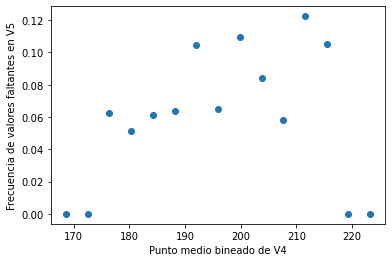

In [13]:
plt.scatter(vf_V4V5['bin_centres'], vf_V4V5['freq'])
plt.xlabel('Punto medio bineado de V4')
plt.ylabel('Frecuencia de valores faltantes en V5')
plt.show()

¿Te parece que da alguna información este gráfico? No te apures a sacar conclusiones. Vuelve a repetir los pasos, pero invirtiendo el rol de `V5` y `V4` - solamente tienes que copiar cada celda e intercalar los nombres. Una vez que hayas llegado al gráfico, ahora sí mira si puedes sacar alguna conclusión.

In [14]:
data['V5-intervalos'] = pd.cut(data.V5, bins  = 15)
data

V1   V2           V3          V4           V5       V4-intervalos  \
0     C  1.0   986.175237  184.258917  2224.638050  (182.265, 186.168]   
1     C  1.0   994.130276         NaN  2570.213101                 NaN   
2     A  1.0   985.782622  196.893581  2309.238832  (193.974, 197.876]   
3     A  1.0  1029.464887  192.063247  2349.259233  (190.071, 193.974]   
4     A  1.0  1004.357092         NaN  2474.036357                 NaN   
...  ..  ...          ...         ...          ...                 ...   
1495  C  0.0   985.188653  190.366109  2302.000694  (190.071, 193.974]   
1496  C  0.0   991.730134  193.553401  2277.045998  (190.071, 193.974]   
1497  B  0.0  1032.150519         NaN  2347.760632                 NaN   
1498  C  1.0   984.522924  196.373516  2393.847484  (193.974, 197.876]   
1499  C  0.0  1017.399835  192.406202  2368.906782  (190.071, 193.974]   

             V5-intervalos  
0     (2178.049, 2235.445]  
1      (2522.424, 2579.82]  
2     (2292.841, 2350.236]  
3     (2292.841, 2350.236]  
4     (2465.028, 2522.424]  
...                    ...  
1495  (2292.841, 2350.236]  
1496  (2235.445, 2292.841]  
1497  (2292.841, 2350.236]  
1498  (2350.236, 2407.632]  
1499  (2350.236, 2407.632]  

[1500 rows x 7 columns]

In [15]:
vf_V5V4 = data.V4.isnull().groupby([data['V5-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V5V4

V5-intervalos  count
0     (2005.0, 2063.257]      0
1   (2063.257, 2120.653]      1
2   (2120.653, 2178.049]      0
3   (2178.049, 2235.445]      4
4   (2235.445, 2292.841]      9
5   (2292.841, 2350.236]     26
6   (2350.236, 2407.632]     39
7   (2407.632, 2465.028]     58
8   (2465.028, 2522.424]     79
9    (2522.424, 2579.82]     79
10   (2579.82, 2637.216]     48
11  (2637.216, 2694.612]     25
12  (2694.612, 2752.008]      7
13  (2752.008, 2809.403]      6
14  (2809.403, 2866.799]      3

In [16]:
vf_V5V4['freq'] = vf_V5V4['count']/data.groupby([data['V5-intervalos']]).count()['V5'].values
vf_V5V4

V5-intervalos  count      freq
0     (2005.0, 2063.257]      0  0.000000
1   (2063.257, 2120.653]      1  0.040000
2   (2120.653, 2178.049]      0  0.000000
3   (2178.049, 2235.445]      4  0.049383
4   (2235.445, 2292.841]      9  0.058824
5   (2292.841, 2350.236]     26  0.134715
6   (2350.236, 2407.632]     39  0.157895
7   (2407.632, 2465.028]     58  0.254386
8   (2465.028, 2522.424]     79  0.461988
9    (2522.424, 2579.82]     79  0.612403
10   (2579.82, 2637.216]     48  0.716418
11  (2637.216, 2694.612]     25  1.000000
12  (2694.612, 2752.008]      7  0.875000
13  (2752.008, 2809.403]      6  1.000000
14  (2809.403, 2866.799]      3  1.000000

In [17]:
vf_V5V4["bin_centres"] = vf_V5V4["V5-intervalos"].apply(lambda x: x.mid)
vf_V5V4

V5-intervalos  count      freq bin_centres
0     (2005.0, 2063.257]      0  0.000000   2034.1285
1   (2063.257, 2120.653]      1  0.040000   2091.9550
2   (2120.653, 2178.049]      0  0.000000   2149.3510
3   (2178.049, 2235.445]      4  0.049383   2206.7470
4   (2235.445, 2292.841]      9  0.058824   2264.1430
5   (2292.841, 2350.236]     26  0.134715   2321.5385
6   (2350.236, 2407.632]     39  0.157895   2378.9340
7   (2407.632, 2465.028]     58  0.254386   2436.3300
8   (2465.028, 2522.424]     79  0.461988   2493.7260
9    (2522.424, 2579.82]     79  0.612403   2551.1220
10   (2579.82, 2637.216]     48  0.716418   2608.5180
11  (2637.216, 2694.612]     25  1.000000   2665.9140
12  (2694.612, 2752.008]      7  0.875000   2723.3100
13  (2752.008, 2809.403]      6  1.000000   2780.7055
14  (2809.403, 2866.799]      3  1.000000   2838.1010

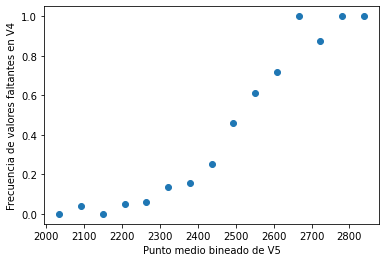

In [18]:
plt.scatter(vf_V5V4['bin_centres'], vf_V5V4['freq'])
plt.xlabel('Punto medio bineado de V5')
plt.ylabel('Frecuencia de valores faltantes en V4')
plt.show()

¿Has llegado a alguna conclusión? Entre `V4` y `V5`, ¿cuál es MNAR y cuál MCAR?¿Y `V2`?

## 1.2 Imputación de valores faltantes

Vamos a *imputar* los valores faltantes. Te recomendamos que:

1. Al tratarse de un dataset pequeño, puedes copiar el dataset, dejar a un lado el original y rellenar valores faltantes en la copia. De esta forma, podrás evaluar tu estrategia (ver punto siguiente) y/o comparar distintas estrategias.
1. Haz histogramas de las variables con y sin valores faltantes. Al imputar, ¿cambián las distribuciones?¿Esto está bien o mal?

**Ejercicio 1 - Challenge:** Comienza con una estrategia sencilla, imputar con el valor medio de cada columna usando Pandas. ¿Para cuáles columnas tendrá sentido esto, teniendo en cuenta lo visto en el punto anterior? 

**Ejercicio 2:** Propone - e implementa - una estrategia que consideres mejor, incorporando la información del punto 1. En el siguiente encuentro, te daremos el dataset sin valores faltantes, por lo que podrás comparar tus resultados. ¡Ten en cuenta que es muy raro que esto se pueda hacer! Lo que nos lleva a...

**Ejercicio 3:** ¿Se te ocurre algún mecanismo de evaluación de tu estrategia? Pista: considera lo que vimos sobre Machine Learning en el Bloque 1 de la carrera. 

Por las dudas, comenzamos volviendo a cargar los datos:

In [19]:
data = pd.read_csv('DS_Bitácora_19_Data_con_VF.csv')
data_copy = data.copy()
data_copy.fillna(data_copy.mean(),inplace = True)
data_copy.isna().sum()

V1    0
V2    0
V3    0
V4    0
V5    0
dtype: int64

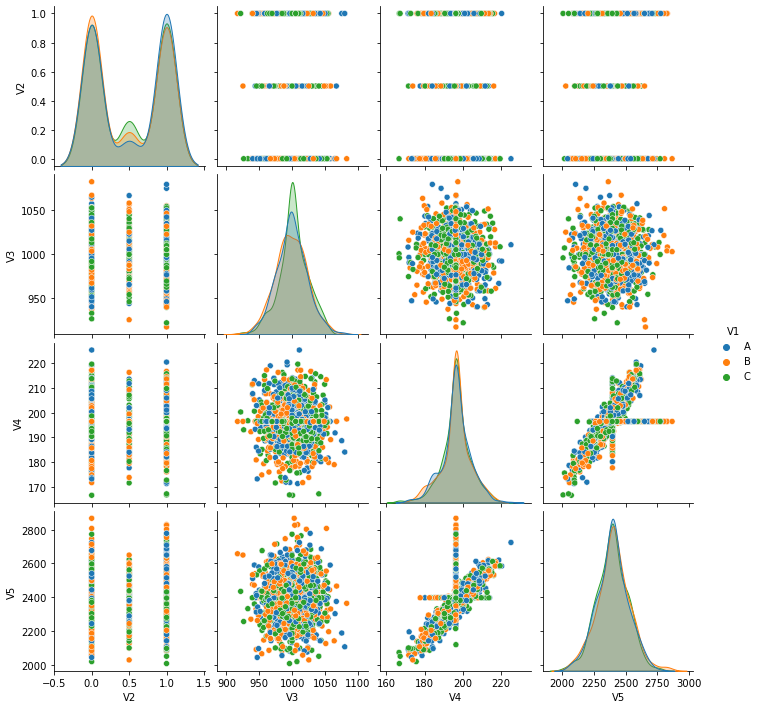

In [20]:
sns.pairplot(data_copy, hue = 'V1', hue_order=['A', 'B', 'C'])
plt.show()

### 1.2.2 Distrofia

La Distrofia Muscular de Duchenne (DMD) es una enfermedad que se transmite genéticamente de madres a hijos e hijas. Mientras que los varones mueren a temprana edad, las mujeres pueden llevar la enfermedad sin saberlo y sin síntomas. Se estima que 1 de cada 3300 mujeres son portadoras de la enfermedad.

Si bien portadoras de DMD no suelen tener síntomas, tienden a exhibir elevados niveles de enzimas o proteínas del suero, como creatina quinasa (CK, por sus siglas en inglés), hemopexina (H), lactato deshidrogenasa (LD) y piruvato quinasa (PK, por sus siglas en inglés). Los niveles de estas enzimas también pueden variar con la edad y la estación. En un estudio llevado a cabo a finales de la década del 70 se midieron esas enzimas en portadoras y no-portadoras de la enfermedad, para estudiar la posibilidad de informar a mujeres la posibilidad de que sean portadoras. Los resultados los pueden encontrar en el archivo `DS_Bitácora_19_Distrofia.csv`.

En este dataset hay valores faltantes en dos de sus columnas. Estos valores faltantes no aparecerán inmediatamente como `NaN` cuando abran el dataset con Pandas, sino que están guardados con un valor en particular. Abre y explora el dataset para descubrir ese valor. Luego, investiga como puedes pasar como argumento a la función de Pandas `read_csv` para que cuando cargue los datos ya los reconozca como valores faltantes. ¿Qué tipo de valores faltantes son?¿Están asociados a los valores de otras columnas? Luego, imputa los valores faltantes. 

In [21]:
data = pd.read_csv('DS_Bitácora_19_Distrofia.csv')

In [22]:
data.head()

edad   mes   año    CK      H    PK     LD  DMD
0  22.0   6.0  79.0  52.0   83.5  10.9  176.0    0
1  32.0   8.0  78.0  20.0   77.0  11.0  200.0    0
2  36.0   7.0  78.0  28.0   86.5  13.2  171.0    0
3  22.0  11.0  79.0  30.0  104.0  22.6  230.0    0
4  23.0   1.0  78.0  40.0   83.0  15.2  205.0    0

In [23]:
for c in data.columns:
    print(f'{c}:')
    print(f'Valor mínimo: {data[c].min()}')
    print(f'Valor máximo: {data[c].max()}\n')

edad:
Valor mínimo: 20.0
Valor máximo: 61.0

mes:
Valor mínimo: 1.0
Valor máximo: 12.0

año:
Valor mínimo: 77.0
Valor máximo: 80.0

CK:
Valor mínimo: 15.0
Valor máximo: 1288.0

H:
Valor mínimo: 9.0
Valor máximo: 118.0

PK:
Valor mínimo: -9999.0
Valor máximo: 110.0

LD:
Valor mínimo: -9999.0
Valor máximo: 593.0

DMD:
Valor mínimo: 0
Valor máximo: 1



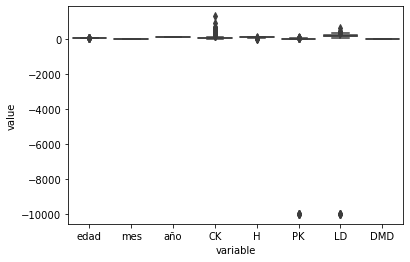

In [24]:
sns.boxplot(x="variable", y="value", data=pd.melt(data));

In [25]:
data.isna().sum()

edad    0
mes     0
año     0
CK      0
H       0
PK      0
LD      0
DMD     0
dtype: int64

In [26]:
data = pd.read_csv('DS_Bitácora_19_Distrofia.csv', na_values=[-9999])

In [27]:
data.isna().sum()

edad    0
mes     0
año     0
CK      0
H       0
PK      8
LD      7
DMD     0
dtype: int64

## 2. Valores Atípicos

Los datos que usaremos en esta sección, "DS_Bitácora_19_Data_VA1.csv" y "DS_Bitácora_19_Data_VA2.csv", fueron simulados con algún criterio desconocido. Uno de los archivos contiene "valores atípicos" y el otro no. El objetivo de esta sección es que decidan en cuál de ellos hay outliers y apliquen las técnicas vistas para detectarlos.

Empieza por uno de los archivos, y, una vez que hayas terminado, repite para el otro.


1. Exploración de datos.
    1. Abrir los datos y explorarlos. Para ello, recomendamos hacer un `distplot` y un `boxplot`. ¿Hay valores atípicos? Si los hay, ¿en qué región del dominio?
    2. Calcular algunos estadísticos sobre la muestra: valor medio, desviación estándar, cuartiles, máximo, mínimo, etc.
2. Manejo de Outliers
    1. Aplicar la técnica del rango interquartílico y la regla de las tres sigmas para seleccionar outliers. ¿Cuántos valores selecciona cada técnica?¿Seleccionan los mismos valores?
    2. Supongamos que seleccionamos outliers y los descartamos. ¿Qué pasa si volvemos a aplicar estas técnicas?

**1. Exploración de Datos**

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [29]:
data = pd.read_csv('DS_Bitácora_19_Data_VA1.csv')
# data = pd.read_csv('DS_Bitácora_19_Data_VA2.csv')
data.head()

Datos
0  2.370556
1  3.437876
2  6.300131
3  5.403170
4  5.722120

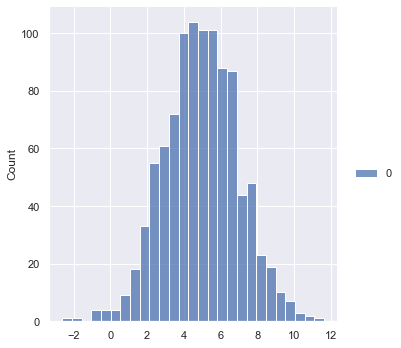

In [30]:
sns.displot(data.values)

/home/esteban/miniconda3/envs/time_series/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

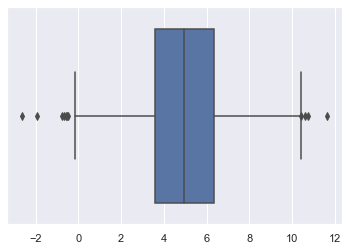

In [31]:
sns.boxplot(data.values)

In [32]:
data.describe()

Datos
count  1000.000000
mean      4.952783
std       2.008023
min      -2.619781
25%       3.607388
50%       4.960488
75%       6.332730
max      11.628151

**2. Manejo de outliers**

No hay una sola forma de aplicar estas reglas.

1. Rango Intercuartílico

In [33]:
q25,q75 = np.percentile(data.Datos.values, [25,75])
iqr = q75 - q25
minimo = q25 - 1.5*iqr
maximo = q75 + 1.5*iqr
print(q25,q75,iqr, minimo, maximo)

3.6073881122339304 6.332730178867589 2.7253420666336585 -0.4806249877165576 10.420743278818076


In [34]:
data.Datos < minimo

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Datos, Length: 1000, dtype: bool

In [35]:
mascara_outliers = (data.Datos < minimo) | (data.Datos > maximo)
mascara_outliers.sum()

11

In [36]:
data[mascara_outliers]

Datos
181  -1.925574
195  -0.486077
309  -0.537363
426  -2.619781
495  -0.601945
525  -0.776018
534  10.626484
540  10.424289
624  11.628151
649  -0.691831
808  10.744420

2. Regla de las tres sigmas

In [37]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data.Datos < minimo, data.Datos > maximo)

In [38]:
mascara_outliers.sum()

3

In [39]:
data[mascara_outliers]

Datos
181  -1.925574
426  -2.619781
624  11.628151

In [40]:
data[~mascara_outliers]

Datos
0    2.370556
1    3.437876
2    6.300131
3    5.403170
4    5.722120
..        ...
995  4.613314
996  4.188867
997  3.394737
998  6.384074
999  4.145870

[997 rows x 1 columns]

## 3. Escalado de datos

Seguiremos usando los datos de la sección anterior:

1. Agregar al dataframe una columna que se llame "Datos_Reescalados" y que contenga los datos reescalados por Z-Score. ¿Cuál es el valor medio de los datos reescalados?¿Y su desviación estándar? **Nota:** Para reescalar los datos, pueden hacerlo "a mano" o utilizar la clase `StandardScaler` de Scikit-Learn. No te olvides que las herramientas de preprocesamiento de datos de Scikit-learn tienen los mismos métodos (crear el objeto, fitearlo, transfromar los datos). Si necesitás ayuda, podés consultar la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Realizá, en un mismo gráfico, un histograma de los datos reescaleados y un histograma de los datos crudos. ¿Qué similitudes y qué diferencias tiene con la distribución de datos crudos?
3. Aplica la regla de las tres sigmas utilizando los datos reescalados.
    

In [41]:
data = pd.read_csv('DS_Bitácora_19_Data_VA1.csv')

In [42]:
data.head()

Datos
0  2.370556
1  3.437876
2  6.300131
3  5.403170
4  5.722120

In [43]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
data['Datos_Reescalados'] = (data.Datos - valor_medio)/std
data.head()

Datos  Datos_Reescalados
0  2.370556          -1.285955
1  3.437876          -0.754427
2  6.300131           0.670982
3  5.403170           0.224294
4  5.722120           0.383131

In [44]:
print(data.Datos_Reescalados.mean(), data.Datos_Reescalados.std())

9.947598300641403e-17 0.9999999999999999


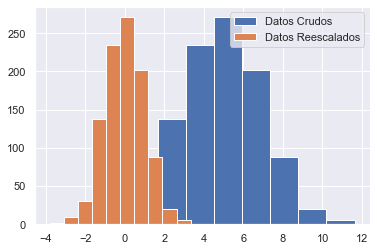

In [45]:
data.Datos.hist(label = 'Datos Crudos')
data.Datos_Reescalados.hist(label = 'Datos Reescalados')
plt.legend()
plt.show()

In [46]:
data[['Datos']]

Datos
0    2.370556
1    3.437876
2    6.300131
3    5.403170
4    5.722120
..        ...
995  4.613314
996  4.188867
997  3.394737
998  6.384074
999  4.145870

[1000 rows x 1 columns]

In [47]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scaler.fit(data[['Datos']])

StandardScaler()

In [48]:
scaler.fit_transform(data[['Datos']])

array([[-1.28659872e+00],
       [-7.54804935e-01],
       [ 6.71318109e-01],
       [ 2.24405943e-01],
       [ 3.83323069e-01],
       [-1.88592849e-01],
       [ 1.25175736e+00],
       [-3.98190178e-01],
       [-2.53183916e+00],
       [-1.12645628e-01],
       [ 1.06948354e-01],
       [ 2.08212128e+00],
       [ 9.40136846e-01],
       [-2.82263587e-01],
       [-1.49350303e+00],
       [-5.17861298e-01],
       [-1.07840627e+00],
       [-1.55624401e-01],
       [ 6.76148010e-01],
       [-1.75815372e+00],
       [ 1.29217890e-02],
       [-1.56744063e+00],
       [-6.32915345e-01],
       [ 3.93825462e-01],
       [-1.40363264e+00],
       [ 1.02181616e+00],
       [ 7.05170941e-02],
       [ 9.28776362e-01],
       [-1.02737514e+00],
       [-1.26803465e+00],
       [ 1.62095337e+00],
       [-1.35221076e-01],
       [-9.78944839e-01],
       [-8.28602766e-01],
       [ 3.25795721e-01],
       [-5.41768914e-01],
       [-2.38679301e-01],
       [-1.60720010e+00],
       [ 6.0

In [49]:
# sns.distplot(data.Datos_Reescalados.values, label = 'Datos Reescalados')
# sns.distplot(data.Datos.values, label = 'Datos Crudos')
# plt.legend()
# plt.show()

In [50]:
mascara_outliers = np.logical_or(data.Datos_Reescalados < -3, data.Datos_Reescalados > 3)
print(mascara_outliers.sum())

3


In [51]:
data[mascara_outliers]

Datos  Datos_Reescalados
181  -1.925574          -3.425438
426  -2.619781          -3.771155
624  11.628151           3.324349

## 4. Encoders

Elige un dataset de los que hayamos usado hasta el momento - puede ser el de Titanic, el de Vinos, el del proyecto o inclusive uno que hayas visto y que te interese - y haz los siguiente ejercicios:

1. ¿De qué tipo es cada atributo?
2. Lleva todos los atributos que te interesen a una forma numérica. ¿Cómo creció tu dataset?
3. Si hay una tarea de regresión o clasificación bien definida sobre ese dataset que te interese explorar, hazlo. Para ello, entrena un modelo de árboles de decisión (no te olvides de seguir todos los pasos de un flujo de Machine Learning: elegir una métrica de evaluación, hacer una `train_test_split`, etc.). ¿Cómo cambia el desempeño del modelo con la incorporación de estos atributos? Recuerda que si utilizas un modelo de vecinos más cercanos, es importante escalar los datos antes.



In [52]:
df_titanic = pd.read_csv('titanic.csv')
df_titanic_original = df_titanic.copy()

In [53]:
df_titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [54]:
for col in df_titanic:
    print(f'Variable: {col}')
    print(f'Valores únicos: {len(df_titanic[col].unique())}')
    print(f'Ejemplos: {df_titanic[col].unique()[:3]}\n')

Variable: PassengerId
Valores únicos: 891
Ejemplos: [1 2 3]

Variable: Survived
Valores únicos: 2
Ejemplos: [0 1]

Variable: Pclass
Valores únicos: 3
Ejemplos: [3 1 2]

Variable: Name
Valores únicos: 891
Ejemplos: ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina']

Variable: Sex
Valores únicos: 2
Ejemplos: ['male' 'female']

Variable: Age
Valores únicos: 89
Ejemplos: [22. 38. 26.]

Variable: SibSp
Valores únicos: 7
Ejemplos: [1 0 3]

Variable: Parch
Valores únicos: 7
Ejemplos: [0 1 2]

Variable: Ticket
Valores únicos: 681
Ejemplos: ['A/5 21171' 'PC 17599' 'STON/O2. 3101282']

Variable: Fare
Valores únicos: 248
Ejemplos: [ 7.25   71.2833  7.925 ]

Variable: Cabin
Valores únicos: 148
Ejemplos: [nan 'C85' 'C123']

Variable: Embarked
Valores únicos: 4
Ejemplos: ['S' 'C' 'Q']



In [55]:
df_titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

In [56]:
dic_sex = {'male': 1,
          'female': 0}

In [57]:
dic_sex

{'male': 1, 'female': 0}

In [58]:
df_titanic['Sex']

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [59]:
df_titanic['Sex'].map(dic_sex)

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

In [60]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_titanic['Sex'])

le.classes_

array(['female', 'male'], dtype=object)

In [61]:
le.transform(df_titanic['Sex'])

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,

In [62]:
df_titanic['Sex'] = le.transform(df_titanic['Sex'])

In [63]:
df_titanic

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1   
2                               Heikkinen, Miss. Laina    0  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1   
4                             Allen, Mr. William Henry    1  35.0      0   
..                                                 ...  ...   ...    ...   
886                              Montvila, Rev. Juozas    1  27.0      0   
887                       Graham, Miss. Margaret Edith    0  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"    0   NaN      1   
889                              Behr, Mr. Karl Howell    1  26.0      0   
890                                Dooley, Mr. Patrick    1  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [64]:
df_titanic['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [65]:
df_titanic['Embarked'] = df_titanic['Embarked'].fillna('O')

In [66]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')


enc.fit(df_titanic[['Embarked']])

OneHotEncoder(handle_unknown='ignore')

In [67]:
enc.categories_[0]

array(['C', 'O', 'Q', 'S'], dtype=object)

In [68]:
enc.transform(df_titanic[['Embarked']]).toarray()

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [69]:
embarked_transformed = enc.transform(df_titanic[['Embarked']]).toarray()

In [70]:
pd.DataFrame(embarked_transformed, columns=enc.categories_[0])

C    O    Q    S
0    0.0  0.0  0.0  1.0
1    1.0  0.0  0.0  0.0
2    0.0  0.0  0.0  1.0
3    0.0  0.0  0.0  1.0
4    0.0  0.0  0.0  1.0
..   ...  ...  ...  ...
886  0.0  0.0  0.0  1.0
887  0.0  0.0  0.0  1.0
888  0.0  0.0  0.0  1.0
889  1.0  0.0  0.0  0.0
890  0.0  0.0  1.0  0.0

[891 rows x 4 columns]

In [71]:
df_titanic.join(pd.DataFrame(embarked_transformed, columns=enc.categories_[0]))

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1   
2                               Heikkinen, Miss. Laina    0  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1   
4                             Allen, Mr. William Henry    1  35.0      0   
..                                                 ...  ...   ...    ...   
886                              Montvila, Rev. Juozas    1  27.0      0   
887                       Graham, Miss. Margaret Edith    0  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"    0   NaN      1   
889                              Behr, Mr. Karl Howell    1  26.0      0   
890                                Dooley, Mr. Patrick    1  32.0      0   

     Parch            Ticket     Fare Cabin Embarked    C    O    Q    S  
0        0         A/5 21171   7.2500   NaN        S  0.0  0.0  0.0  1.0  
1        0          PC 17599  71.2833   C85        C  1.0  0.0  0.0  0.0  
2        0  STON/O2. 3101282   7.9250   NaN        S  0.0  0.0  0.0  1.0  
3        0            113803  53.1000  C123        S  0.0  0.0  0.0  1.0  
4        0            373450   8.0500   NaN        S  0.0  0.0  0.0  1.0  
..     ...               ...      ...   ...      ...  ...  ...  ...  ...  
886      0            211536  13.0000   NaN        S  0.0  0.0  0.0  1.0  
887      0            112053  30.0000   B42        S  0.0  0.0  0.0  1.0  
888      2        W./C. 6607  23.4500   NaN        S  0.0  0.0  0.0  1.0  
889      0            111369  30.0000  C148        C  1.0  0.0  0.0  0.0  
890      0            370376   7.7500   NaN        Q  0.0  0.0  1.0  0.0  

[891 rows x 16 columns]

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_titanic[['Age']])

StandardScaler()

In [73]:
scaler.mean_

array([29.69911765])

In [74]:
df_titanic['Age_transformed'] = scaler.transform(df_titanic[['Age']])

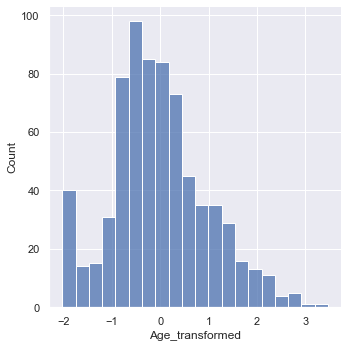

In [75]:
ax = sns.displot(df_titanic['Age_transformed']);

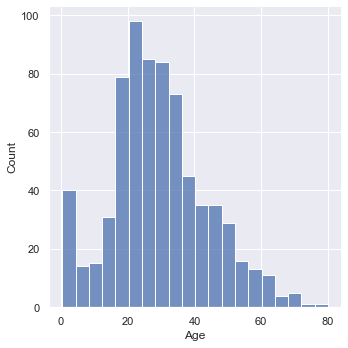

In [76]:
ax = sns.displot(df_titanic['Age']);

In [77]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

scaler.fit(df_titanic[['Age']])


MinMaxScaler()

In [78]:
df_titanic['Age_transformed_minmax'] = scaler.fit_transform(df_titanic[['Age']])

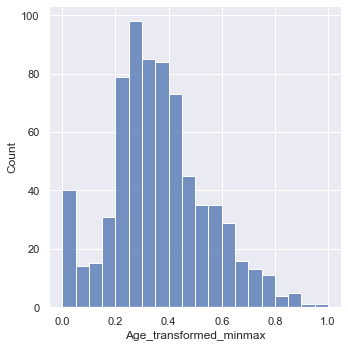

In [79]:
ax = sns.displot(df_titanic['Age_transformed_minmax']);

## Decision Tree

Vamos a aplicar un modelo 'Árbol de decisión' sobre los datos de 'titanic'.

In [80]:
df_titanic = pd.read_csv('titanic.csv')

In [81]:
X = df_titanic.drop('Survived', axis=1)

y = df_titanic['Survived']

In [82]:
X

PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0      male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1    female  38.0      1      0          PC 17599  71.2833   C85        C  
2    female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
3    female  35.0      1      0            113803  53.1000  C123        S  
4      male  35.0      0      0            373450   8.0500   NaN        S  
..      ...   ...    ...    ...               ...      ...   ...      ...  
886    male  27.0      0      0            211536  13.0000   NaN        S  
887  female  19.0      0      0            112053  30.0000   B42        S  
888  female   NaN      1      2        W./C. 6607  23.4500   NaN        S  
889    male  26.0      0      0            111369  30.0000  C148        C  
890    male  32.0      0      0            370376   7.7500   NaN        Q  

[891 rows x 11 columns]

In [83]:
X.head()

PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0          PC 17599  71.2833   C85        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
3  female  35.0      1      0            113803  53.1000  C123        S  
4    male  35.0      0      0            373450   8.0500   NaN        S

## Imputación de valores nulos

In [84]:
X['Embarked'].isna().sum()

2

In [85]:
X[X['Embarked'].isna()]

PassengerId  Pclass                                       Name     Sex  \
61            62       1                        Icard, Miss. Amelie  female   
829          830       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   38.0      0      0  113572  80.0   B28      NaN  
829  62.0      0      0  113572  80.0   B28      NaN

Vamos a realizar una imputación sencilla; colocaremos la moda de la variable:

In [86]:
moda = X['Embarked'].mode()

In [87]:
moda[0]

'S'

In [88]:
X['Embarked'] = X['Embarked'].fillna(moda[0])

In [89]:
from sklearn.impute import SimpleImputer

imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X[['Embarked']])

SimpleImputer(strategy='most_frequent')

In [90]:
imp_mode.fit_transform(X[['Embarked']])

array([['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['Q'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['Q'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['Q'],
       ['S'],
       ['Q'],
       ['Q'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['C'],
       ['C'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
       ['S'],
      

### ---------------------------------------------------

In [91]:
X['Age'].isna().sum()

177

In [92]:
media = X['Age'].mean()

In [93]:
X['Age'] = X['Age'].fillna(media)

### ---------------------------------------------------

In [94]:
X['Sex'].isna().sum()

0

### ---------------------------------------------------

## Transformaciones

In [95]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')


embarked_transformed = enc.fit_transform(X[['Embarked']])

In [96]:
embarked_transformed = pd.DataFrame(embarked_transformed.toarray(),columns=enc.categories_[0])

In [97]:
X = X.drop('Embarked', axis=1)

X = X.join(embarked_transformed)

In [98]:
X

PassengerId  Pclass                                               Name  \
0              1       3                            Braund, Mr. Owen Harris   
1              2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2              3       3                             Heikkinen, Miss. Laina   
3              4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4              5       3                           Allen, Mr. William Henry   
..           ...     ...                                                ...   
886          887       2                              Montvila, Rev. Juozas   
887          888       1                       Graham, Miss. Margaret Edith   
888          889       3           Johnston, Miss. Catherine Helen "Carrie"   
889          890       1                              Behr, Mr. Karl Howell   
890          891       3                                Dooley, Mr. Patrick   

        Sex        Age  SibSp  Parch            Ticket     Fare Cabin    C  \
0      male  22.000000      1      0         A/5 21171   7.2500   NaN  0.0   
1    female  38.000000      1      0          PC 17599  71.2833   C85  1.0   
2    female  26.000000      0      0  STON/O2. 3101282   7.9250   NaN  0.0   
3    female  35.000000      1      0            113803  53.1000  C123  0.0   
4      male  35.000000      0      0            373450   8.0500   NaN  0.0   
..      ...        ...    ...    ...               ...      ...   ...  ...   
886    male  27.000000      0      0            211536  13.0000   NaN  0.0   
887  female  19.000000      0      0            112053  30.0000   B42  0.0   
888  female  29.699118      1      2        W./C. 6607  23.4500   NaN  0.0   
889    male  26.000000      0      0            111369  30.0000  C148  1.0   
890    male  32.000000      0      0            370376   7.7500   NaN  0.0   

       Q    S  
0    0.0  1.0  
1    0.0  0.0  
2    0.0  1.0  
3    0.0  1.0  
4    0.0  1.0  
..   ...  ...  
886  0.0  1.0  
887  0.0  1.0  
888  0.0  1.0  
889  0.0  0.0  
890  1.0  0.0  

[891 rows x 13 columns]

### ---------------------------------------------------

In [99]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

sex_transformed = le.fit_transform(X['Sex'])

#le.classes_

In [100]:
X['Sex'] = sex_transformed

### ---------------------------------------------------

In [101]:
X = X[['Sex', 'Age', 'C', 'Q', 'S']]

In [102]:
X

Sex        Age    C    Q    S
0      1  22.000000  0.0  0.0  1.0
1      0  38.000000  1.0  0.0  0.0
2      0  26.000000  0.0  0.0  1.0
3      0  35.000000  0.0  0.0  1.0
4      1  35.000000  0.0  0.0  1.0
..   ...        ...  ...  ...  ...
886    1  27.000000  0.0  0.0  1.0
887    0  19.000000  0.0  0.0  1.0
888    0  29.699118  0.0  0.0  1.0
889    1  26.000000  1.0  0.0  0.0
890    1  32.000000  0.0  1.0  0.0

[891 rows x 5 columns]

## Modelización de Árbol de Decisión

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [105]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

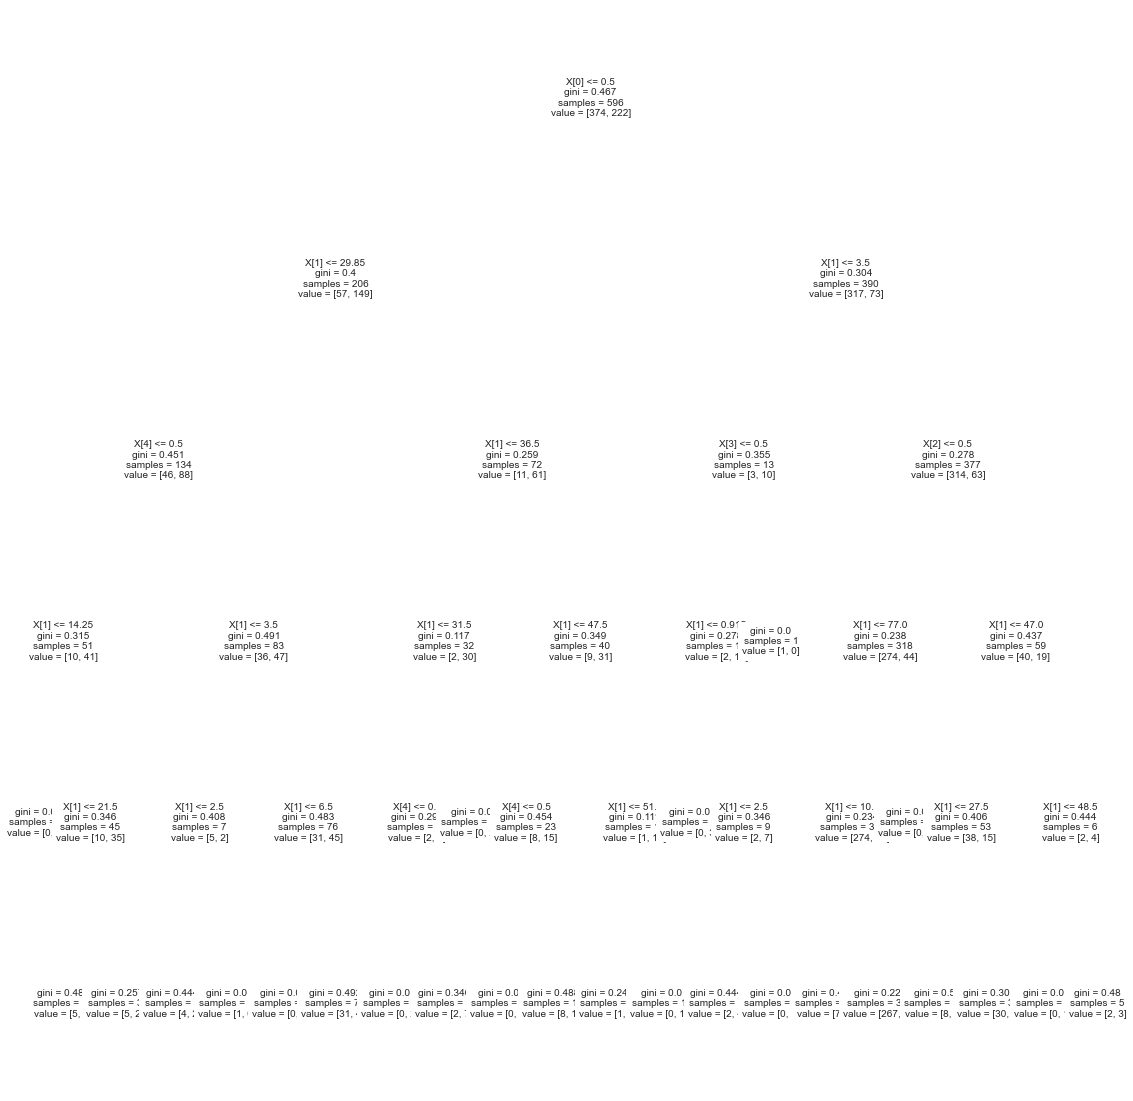

In [106]:
plt.figure(figsize=(20,20))  
plot_tree(clf, fontsize=10)
plt.show()

## Test del Modelo: cálculo y graficación de métricas...

In [107]:
X_test

Sex        Age    C    Q    S
709    1  29.699118  1.0  0.0  0.0
439    1  31.000000  0.0  0.0  1.0
840    1  20.000000  0.0  0.0  1.0
720    0   6.000000  0.0  0.0  1.0
39     0  14.000000  1.0  0.0  0.0
..   ...        ...  ...  ...  ...
715    1  19.000000  0.0  0.0  1.0
525    1  40.500000  0.0  1.0  0.0
381    0   1.000000  1.0  0.0  0.0
140    0  29.699118  1.0  0.0  0.0
173    1  21.000000  0.0  0.0  1.0

[295 rows x 5 columns]

In [108]:
y_pred = clf.predict(X_test)

In [109]:
df = pd.DataFrame()

In [110]:
df['real'] = y_test
df['pred'] = y_pred

In [111]:
df

real  pred
709     1     0
439     0     0
840     0     0
720     1     1
39      1     1
..    ...   ...
715     0     0
525     0     0
381     1     1
140     0     1
173     0     0

[295 rows x 2 columns]

In [112]:
from sklearn.metrics import classification_report

In [113]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       175
           1       0.72      0.72      0.73       120

    accuracy                           0.78       295
   macro avg       0.77      0.77      0.77       295
weighted avg       0.78      0.78      0.78       295



In [114]:
clf.predict_proba(X_test)

array([[0.81081081, 0.18918919],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.43661972, 0.56338028],
       [0.15151515, 0.84848485],
       [0.86970684, 0.13029316],
       [0.41666667, 0.58333333],
       [0.43661972, 0.56338028],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.43661972, 0.56338028],
       [0.81081081, 0.18918919],
       [0.86970684, 0.13029316],
       [0.43661972, 0.56338028],
       [0.86970684, 0.13029316],
       [0.15151515, 0.84848485],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.43661972, 0.56338028],
       [0.86970684, 0.13029316],
       [0.86970684, 0.13029316],
       [0.7       , 0.3       ],
       [0.81081081, 0.18918919],
       [0.86970684, 0.13029316],
       [0.7       , 0.3       ],
       [0.22222222, 0.77777778],
       [0.